#第一步：导入包和定义RVM类

In [116]:
import os
import math
import time
import datetime
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams ['font.sans-serif'] ='SimHei'               #显示中文
plt.rcParams ['axes.unicode_minus']=False               #显示负号
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import GRU, Dense,Conv1D, MaxPooling1D,GlobalMaxPooling1D,Embedding,Dropout,Flatten,SimpleRNN,LSTM
from keras.callbacks import EarlyStopping
#from tensorflow.keras import regularizers
#from keras.utils.np_utils import to_categorical
from tensorflow.keras  import optimizers
from sklearn.datasets import  make_regression
from sklearn.model_selection import train_test_split

定义RVM中的回归学习RVR，没包括二分类RVC

In [117]:
"""Relevance Vector Machine classes for regression and classification."""
from scipy.optimize import minimize
from scipy.special import expit
 
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics.pairwise import (
    linear_kernel,
    rbf_kernel,
    polynomial_kernel
)
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils.validation import check_X_y
 
class BaseRVM(BaseEstimator):
 
    """Base Relevance Vector Machine class.
    Implementation of Mike Tipping's Relevance Vector Machine using the
    scikit-learn API. Add a posterior over weights method and a predict
    in subclass to use for classification or regression.
    """
 
    def __init__(
        self,
        kernel='rbf',
        degree=3,
        coef1=None,
        coef0=0.0,
        n_iter=3000,
        tol=1e-3,
        alpha=1e-6,
        threshold_alpha=1e9,
        beta=1.e-6,
        beta_fixed=False,
        bias_used=True,
        verbose=False
    ):
        """Copy params to object properties, no validation."""
        self.kernel = kernel
        self.degree = degree
        self.coef1 = coef1
        self.coef0 = coef0
        self.n_iter = n_iter
        self.tol = tol
        self.alpha = alpha
        self.threshold_alpha = threshold_alpha
        self.beta = beta
        self.beta_fixed = beta_fixed
        self.bias_used = bias_used
        self.verbose = verbose
 
    def get_params(self, deep=True):
        """Return parameters as a dictionary."""
        params = {
            'kernel': self.kernel,
            'degree': self.degree,
            'coef1': self.coef1,
            'coef0': self.coef0,
            'n_iter': self.n_iter,
            'tol': self.tol,
            'alpha': self.alpha,
            'threshold_alpha': self.threshold_alpha,
            'beta': self.beta,
            'beta_fixed': self.beta_fixed,
            'bias_used': self.bias_used,
            'verbose': self.verbose
        }
        return params
 
    def set_params(self, **parameters):
        """Set parameters using kwargs."""
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
 
    def _apply_kernel(self, x, y):
        """Apply the selected kernel function to the data."""
        if self.kernel == 'linear':
            phi = linear_kernel(x, y)
        elif self.kernel == 'rbf':
            phi = rbf_kernel(x, y, self.coef1)
        elif self.kernel == 'poly':
            phi = polynomial_kernel(x, y, self.degree, self.coef1, self.coef0)
        elif callable(self.kernel):
            phi = self.kernel(x, y)
            if len(phi.shape) != 2:
                raise ValueError(
                    "Custom kernel function did not return 2D matrix"
                )
            if phi.shape[0] != x.shape[0]:
                raise ValueError(
                    "Custom kernel function did not return matrix with rows"
                    " equal to number of data points."""
                )
        else:
            raise ValueError("Kernel selection is invalid.")
 
        if self.bias_used:
            phi = np.append(phi, np.ones((phi.shape[0], 1)), axis=1)
 
        return phi
 
    def _prune(self):
        """Remove basis functions based on alpha values."""
        keep_alpha = self.alpha_ < self.threshold_alpha
 
        if not np.any(keep_alpha):
            keep_alpha[0] = True
            if self.bias_used:
                keep_alpha[-1] = True
 
        if self.bias_used:
            if not keep_alpha[-1]:
                self.bias_used = False
            self.relevance_ = self.relevance_[keep_alpha[:-1]]
        else:
            self.relevance_ = self.relevance_[keep_alpha]
 
        self.alpha_ = self.alpha_[keep_alpha]
        self.alpha_old = self.alpha_old[keep_alpha]
        self.gamma = self.gamma[keep_alpha]
        self.phi = self.phi[:, keep_alpha]
        self.sigma_ = self.sigma_[np.ix_(keep_alpha, keep_alpha)]
        self.m_ = self.m_[keep_alpha]
 
    def fit(self, X, y):
        """Fit the RVR to the training data."""
        X, y = check_X_y(X, y)
 
        n_samples, n_features = X.shape
 
        self.phi = self._apply_kernel(X, X)
 
        n_basis_functions = self.phi.shape[1]
 
        self.relevance_ = X
        self.y = y
 
        self.alpha_ = self.alpha * np.ones(n_basis_functions)
        self.beta_ = self.beta
 
        self.m_ = np.zeros(n_basis_functions)
 
        self.alpha_old = self.alpha_
 
        for i in range(self.n_iter):
            self._posterior()
 
            self.gamma = 1 - self.alpha_*np.diag(self.sigma_)
            self.alpha_ = self.gamma/(self.m_ ** 2)
 
            if not self.beta_fixed:
                self.beta_ = (n_samples - np.sum(self.gamma))/(
                    np.sum((y - np.dot(self.phi, self.m_)) ** 2))
 
            self._prune()
 
            if self.verbose:
                print("Iteration: {}".format(i))
                print("Alpha: {}".format(self.alpha_))
                print("Beta: {}".format(self.beta_))
                print("Gamma: {}".format(self.gamma))
                print("m: {}".format(self.m_))
                print("Relevance Vectors: {}".format(self.relevance_.shape[0]))
                print()
 
            delta = np.amax(np.absolute(self.alpha_ - self.alpha_old))
 
            if delta < self.tol and i > 1:
                break
 
            self.alpha_old = self.alpha_
 
        if self.bias_used:
            self.bias = self.m_[-1]
        else:
            self.bias = None
 
        return self
 
class RVR(BaseRVM, RegressorMixin):
 
    """Relevance Vector Machine Regression.
    Implementation of Mike Tipping's Relevance Vector Machine for regression
    using the scikit-learn API.
    """
 
    def _posterior(self):
        """Compute the posterior distriubtion over weights."""
        i_s = np.diag(self.alpha_) + self.beta_ * np.dot(self.phi.T, self.phi)
        self.sigma_ = np.linalg.inv(i_s)
        self.m_ = self.beta_ * np.dot(self.sigma_, np.dot(self.phi.T, self.y))
 
    def predict(self, X, eval_MSE=False):
        """Evaluate the RVR model at x."""
        phi = self._apply_kernel(X, self.relevance_)
 
        y = np.dot(phi, self.m_)
 
        if eval_MSE:
            MSE = (1/self.beta_) + np.dot(phi, np.dot(self.sigma_, phi.T))
            return y, MSE[:, 0]
        else:
            return y

In [118]:
#第二步 导入数据
df = pd.read_csv("B0018.csv")
df.head()

,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）,容量
0,1,3.527546,31.773285,1559.375,1.855005
1,2,3.534836,31.924892,1581.110,1.843196
2,3,3.538247,31.316913,1582.438,1.839602
3,4,3.537698,30.821191,1572.984,1.830674
4,5,3.542668,31.953470,1592.500,1.832700


In [119]:
X=df.iloc[:,:-1]

In [120]:
capacity_original_half = np.array(df)[:20,4]

In [121]:
X

,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）
0,1,3.527546,31.773285,1559.375
1,2,3.534836,31.924892,1581.110
2,3,3.538247,31.316913,1582.438
3,4,3.537698,30.821191,1572.984
4,5,3.542668,31.953470,1592.500
...,...,...,...,...
127,128,3.455229,31.818465,872.500
128,129,3.461974,32.000672,858.765
129,130,3.452222,31.739922,847.656
130,131,3.447650,31.526136,835.906


In [122]:
y=df.iloc[:,-1]

In [123]:
y

0      1.855005
1      1.843196
2      1.839602
3      1.830674
4      1.832700
         ...   
127    1.362737
128    1.363405
129    1.351865
130    1.354797
131    1.341051
Name: 容量, Length: 132, dtype: float64

In [124]:
#取出X和y,标准化
scaler_s = StandardScaler()
scaler_s.fit(X)
X_s = scaler_s.transform(X)

 拟合RVM模型，选取三种核函数，看哪个拟合程度高，对比出来rbf，即高斯径向基函数达到0.998，最好，所以选取这个核函数

In [125]:
#三种常用的核函数
rvm_model_linear = RVR(kernel="linear")
rvm_model_linear.fit(X_s, y)
print(rvm_model_linear.score(X_s, y))
 
rvm_model_rbf = RVR(kernel="rbf")
rvm_model_rbf.fit(X_s, y)
print(rvm_model_rbf.score(X_s, y))
 
rvm_model_poly = RVR(kernel="poly")
rvm_model_poly.fit(X_s, y)
print(rvm_model_poly.score(X_s, y))

0.9960109597052496
0.9980813688669362
0.8813498427405416


In [126]:
#第三步 划分
df_for_training=df[:120]
df_for_testing= df[0:]

In [127]:
#第四步最大最小归一化
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaler = scaler.fit_transform(df_for_training)
df_for_testing_scaler=scaler.fit_transform(df_for_testing)

In [128]:
#第五步构构建训练集和测试集
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past,len(dataset)):
        dataX.append(dataset[i-n_past:i,0:dataset.shape[1]])
        dataY.append(dataset[i,4])
    return np.array(dataX),np.array(dataY)

trainX,trainY = createXY(df_for_training_scaler,20)
testX,testY = createXY(df_for_testing_scaler,20)

In [129]:
trainX[2]

array([[0.01680672, 0.90991922, 0.632266  , 0.98435538, 0.96972587],
       [0.02521008, 0.90458638, 0.37413235, 0.97190029, 0.95217732],
       [0.03361345, 0.95289107, 0.96373551, 0.99761148, 0.95616063],
       [0.04201681, 0.97657003, 1.        , 1.        , 0.94796186],
       [0.05042017, 1.        , 0.79765806, 0.97144841, 0.93355919],
       [0.05882353, 0.97373863, 0.61731194, 0.95734651, 0.92170485],
       [0.06722689, 0.9607683 , 0.52515957, 0.95526891, 0.9003359 ],
       [0.07563025, 0.95741668, 0.53580581, 0.97898154, 0.93729178],
       [0.08403361, 0.97706976, 0.73440308, 0.96553968, 0.91572054],
       [0.09243697, 0.97587636, 0.62920044, 0.94964739, 0.90110949],
       [0.10084034, 0.96670902, 0.41202739, 0.92031455, 0.8738925 ],
       [0.1092437 , 0.93976435, 0.2280219 , 0.90316673, 0.85939956],
       [0.11764706, 0.93860643, 0.37645969, 0.91197778, 0.85442267],
       [0.12605042, 0.93916514, 0.70229685, 0.90129465, 0.83529909],
       [0.13445378, 0.95367148, 0.

In [130]:
trainY[1]

0.7122305106822115

In [131]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)

(100, 20, 5)
(100,)
(112, 20, 5)


In [132]:
trainX_2D=(trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]))
testX_2D=(testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]))

In [133]:
print(trainX_2D.shape)
print(testX_2D.shape)

(100, 100)
(112, 100)


In [134]:
trainX[21]

array([[0.17647059, 0.8043654 , 0.07731745, 0.78288828, 0.71223051],
       [0.18487395, 0.82590026, 0.05712531, 0.76403306, 0.71788129],
       [0.19327731, 0.81975894, 0.01161589, 0.7454242 , 0.7100825 ],
       [0.20168067, 0.85186787, 0.06331077, 0.79417085, 0.79211519],
       [0.21008403, 0.85346328, 0.45494094, 0.78702636, 0.75974619],
       [0.21848739, 0.89120386, 0.68370822, 0.7809332 , 0.73903289],
       [0.22689076, 0.86412555, 0.66683521, 0.76117289, 0.718621  ],
       [0.23529412, 0.80072805, 0.55469137, 0.72479833, 0.69389789],
       [0.24369748, 0.822544  , 0.46447755, 0.71683176, 0.68361593],
       [0.25210084, 0.80858812, 0.49604767, 0.68115808, 0.65976655],
       [0.2605042 , 0.78789887, 0.66196422, 0.67397408, 0.65008514],
       [0.26890756, 0.77529497, 0.75951563, 0.66808643, 0.62757192],
       [0.27731092, 0.74031617, 0.63307931, 0.64223164, 0.61119829],
       [0.28571429, 0.72728861, 0.52140392, 0.62421958, 0.593571  ],
       [0.29411765, 0.66613399, 0.

In [135]:
trainX_2D[21]

array([0.17647059, 0.8043654 , 0.07731745, 0.78288828, 0.71223051,
       0.18487395, 0.82590026, 0.05712531, 0.76403306, 0.71788129,
       0.19327731, 0.81975894, 0.01161589, 0.7454242 , 0.7100825 ,
       0.20168067, 0.85186787, 0.06331077, 0.79417085, 0.79211519,
       0.21008403, 0.85346328, 0.45494094, 0.78702636, 0.75974619,
       0.21848739, 0.89120386, 0.68370822, 0.7809332 , 0.73903289,
       0.22689076, 0.86412555, 0.66683521, 0.76117289, 0.718621  ,
       0.23529412, 0.80072805, 0.55469137, 0.72479833, 0.69389789,
       0.24369748, 0.822544  , 0.46447755, 0.71683176, 0.68361593,
       0.25210084, 0.80858812, 0.49604767, 0.68115808, 0.65976655,
       0.2605042 , 0.78789887, 0.66196422, 0.67397408, 0.65008514,
       0.26890756, 0.77529497, 0.75951563, 0.66808643, 0.62757192,
       0.27731092, 0.74031617, 0.63307931, 0.64223164, 0.61119829,
       0.28571429, 0.72728861, 0.52140392, 0.62421958, 0.593571  ,
       0.29411765, 0.66613399, 0.46189474, 0.59640971, 0.57498

In [136]:
trainY[1],trainY[2]

(0.7122305106822115, 0.7178812908046766)

In [137]:
#第六步模型构建
#固定随机种子
def set_my_seed():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(1)
    rn.seed(12345)
    tf.random.set_seed(123)


In [138]:
##创建并拟合RVM模型
model = RVR(kernel='linear')
model.fit(trainX_2D,trainY)

RVR(kernel='linear')

In [139]:
prediction= model.predict(testX_2D)
prediction_1 = prediction.reshape(-1,1)#重要的一步，将一行148列转为148列一行，这才是预测的容量

In [140]:
print("prediction\n",prediction_1)
print("\nPrediction Shape-",prediction_1.shape)

prediction
 [[ 0.7935243 ]
 [ 0.74061585]
 [ 0.7655058 ]
 [ 0.78818319]
 [ 0.80507208]
 [ 0.79591716]
 [ 0.71949977]
 [ 0.68030355]
 [ 0.69157292]
 [ 0.70017099]
 [ 0.6959724 ]
 [ 0.62774662]
 [ 0.58812694]
 [ 0.58242039]
 [ 0.60191829]
 [ 0.59945275]
 [ 0.5763075 ]
 [ 0.55063656]
 [ 0.54832005]
 [ 0.57847052]
 [ 0.63256682]
 [ 0.59397886]
 [ 0.55391408]
 [ 0.53779517]
 [ 0.55503992]
 [ 0.58968698]
 [ 0.6489977 ]
 [ 0.67751742]
 [ 0.63044515]
 [ 0.6254387 ]
 [ 0.63231687]
 [ 0.60954348]
 [ 0.60465882]
 [ 0.57025287]
 [ 0.52279917]
 [ 0.58157435]
 [ 0.54065625]
 [ 0.50238166]
 [ 0.494939  ]
 [ 0.48636433]
 [ 0.48700369]
 [ 0.46600568]
 [ 0.41991291]
 [ 0.43015063]
 [ 0.42310986]
 [ 0.42361711]
 [ 0.369164  ]
 [ 0.32364974]
 [ 0.33573684]
 [ 0.33670602]
 [ 0.34268174]
 [ 0.35678887]
 [ 0.3320585 ]
 [ 0.29530674]
 [ 0.28133763]
 [ 0.28497573]
 [ 0.29208081]
 [ 0.27434468]
 [ 0.2633025 ]
 [ 0.2509073 ]
 [ 0.2439744 ]
 [ 0.24067577]
 [ 0.22721097]
 [ 0.22140022]
 [ 0.2223576 ]
 [ 0.22273733

In [141]:
#第八步
prediction_copy = np.repeat(prediction_1,5,axis= -1)
pred = scaler.inverse_transform(np.reshape(prediction_copy,(len(prediction_1),5)))[:,4]

In [142]:
pred.shape

(112,)

In [143]:
original_copy = np.repeat(testY,5,axis=-1)
original = scaler.inverse_transform(np.reshape(original_copy,(len(testY),5)))[:,4]

In [144]:
print("Pred Values-",pred)
print("\nOriginal Valuse_",original)

Pred Values- [1.7488857  1.72169324 1.73448551 1.74614062 1.75482072 1.75011552
 1.71084056 1.69069555 1.69648747 1.70090648 1.6987486  1.66368375
 1.64332109 1.6403882  1.6504092  1.64914203 1.63724645 1.6240528
 1.62286222 1.63835815 1.66616111 1.64632871 1.62573729 1.61745293
 1.62631592 1.64412288 1.67460581 1.6892636  1.66507067 1.66249759
 1.66603265 1.65432819 1.65181771 1.63413466 1.60974569 1.63995337
 1.61892338 1.59925204 1.59542686 1.59101989 1.59134849 1.58055649
 1.55686697 1.56212868 1.55851006 1.55877076 1.53078442 1.50739222
 1.51360442 1.51410254 1.51717377 1.52442418 1.51171393 1.49282525
 1.48564578 1.4875156  1.49116728 1.48205173 1.47637657 1.47000602
 1.46644284 1.46474749 1.45782722 1.45484077 1.45533282 1.45552798
 1.46368825 1.44712555 1.43864321 1.43576151 1.45046046 1.45989512
 1.45372315 1.42588078 1.40848679 1.41919937 1.41816153 1.41550286
 1.4041331  1.39726863 1.39887119 1.39321889 1.37107328 1.37652103
 1.38111473 1.39088294 1.42595992 1.42067501 1.435

In [145]:
capacity_original_complete =np.append(capacity_original_half,original)
pred_complete = np.append(capacity_original_half,pred)

In [146]:
print(capacity_original_complete.shape)
print(pred_complete.shape)

(132,)
(132,)


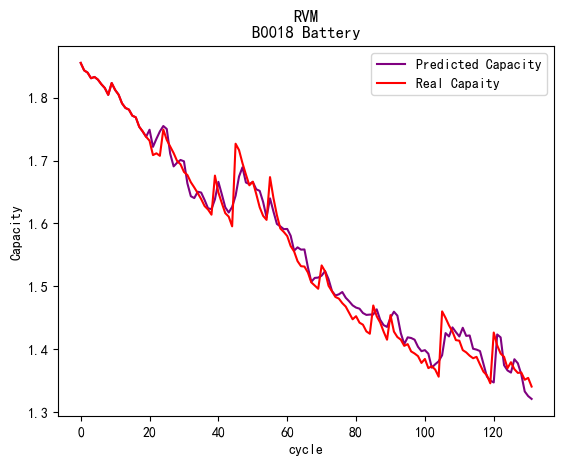

In [147]:
#第九步
plt.plot(pred_complete,color = 'purple',label = 'Predicted Capacity')
plt.plot(capacity_original_complete,color= 'red',label = 'Real Capaity')
plt.title('RVM\nB0018 Battery')
plt.xlabel('cycle')
plt.ylabel('Capacity')
plt.legend()
plt.show()

In [148]:
#第十步
print("mean_absolute_error MAE:", mean_absolute_error(original, pred))
print("mean_squared_error MSE:", mean_squared_error(original, pred))
print("rmse:", sqrt(mean_squared_error(original, pred)))
print("r2 score:", r2_score(original, pred))

mean_absolute_error MAE: 0.01676014187058276
mean_squared_error MSE: 0.00047233555695643897
rmse: 0.021733282240757813
r2 score: 0.969100879831273


# 从起点80开始预测

In [149]:
df_cycle_past = df.iloc[59:79,:]

In [150]:
df_cycle_past

,循环次数,平均放电电压,平均放电温度,等压降放电时间（3.8V-3.5V）,容量
59,60,3.507660,30.843513,1174.234,1.586601
60,61,3.507483,30.797157,1169.125,1.580077
61,62,3.502387,30.984435,1158.828,1.564173
62,63,3.503693,30.967899,1139.172,1.555618
63,64,3.498995,30.976616,1120.093,1.540205
64,65,3.495406,30.897690,1099.375,1.532161
65,66,3.494528,30.815688,1104.015,1.531623
66,67,3.496255,30.726188,1082.891,1.522260
67,68,3.487696,30.768187,1073.360,1.506527
68,69,3.486548,30.775415,1056.219,1.501422


In [151]:
df_cycle_feature = pd.read_csv("B5_test.csv")

In [152]:
df_cycle_feature

,循环次数,平均放电电压,平均放电温度,等压降放电时间,容量
0,81,3.514773,32.219976,1180.563,1.559766
1,82,3.513299,32.712023,1170.906,1.559482
2,83,3.514485,32.945022,1162.032,1.554689
3,84,3.510968,32.857550,1152.125,1.548874
4,85,3.510936,32.629663,1142.672,1.538237
...,...,...,...,...,...
83,164,3.466462,33.275688,805.656,1.293464
84,165,3.468509,33.320678,796.281,1.288003
85,166,3.466806,33.373150,795.937,1.287453
86,167,3.471071,33.713519,824.375,1.309015


In [153]:
df_cycle_feature = pd.read_csv("B5_test.csv")

In [154]:
df_cycle_feature["容量"]=0

In [155]:

old_scaled_array = scaler.transform(df_cycle_past)
new_scaled_array = scaler.transform(df_cycle_feature)
new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,4] = np.nan
full_df = pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
                     

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 等压降放电时间
Feature names seen at fit time, yet now missing:
- 等压降放电时间（3.8V-3.5V）


In [ ]:
full_df_scaled_array = full_df.values
all_data=[]
time_step=20
for i in range (time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    data_x_2D=(data_x.reshape(data_x.shape[0], data_x.shape[1] * data_x.shape[2]))
    prediction = model.predict(data_x_2D)
    print(prediction)
    all_data.append(prediction)
    full_df.iloc[i,4] = prediction

In [ ]:
prediction.shape

In [ ]:
prediction_2 = prediction.reshape(-1,1)

In [ ]:
new_array = np.array(all_data)
new_array = new_array.reshape(-1,1)
prediction_copy_array =np.repeat(new_array,5,axis=-1)
y_pred_future_cycle = scaler.inverse_transform(np.reshape(prediction_copy_array,(len(new_array),5)))[:,4]
print(y_pred_future_cycle)

In [ ]:
capacity_original_half = np.array(df)[:80,4]
capacity_original_complete = np.array(df)[:,4]
len(capacity_original_half)

In [ ]:
pred_complete = np.append(capacity_original_half,y_pred_future_cycle)

In [ ]:
len(pred_complete)

In [ ]:
len(capacity_original_complete)

In [ ]:
plt.plot(pred_complete,color = 'purple',label = 'Predicted Capacity')
plt.plot(capacity_original_complete,color = 'red',label = 'Real Capacity')
plt.title('RVM\nB0005 Battery')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.show()

In [ ]:
print("mean_absolute_error MAE:", mean_absolute_error(capacity_original_complete, pred_complete))
print("mean_squared_error MSE:", mean_squared_error(capacity_original_complete, pred_complete))
print("rmse:", sqrt(mean_squared_error(capacity_original_complete, pred_complete)))
print("r2 score:", r2_score(capacity_original_complete, pred_complete))